損失関数はパラメータ$\theta$と、その推定値${\hat \theta}$の関数である  
$$
L(\theta, {\hat \theta}) = f(\theta, {\hat \theta})
$$

二乗誤差  
$$
L(\theta, {\hat \theta}) = (\theta - {\hat \theta})^2
$$

非対称な二乗誤差(推定値が真の値より大きいほうが小さいより望ましい場合)  
$$
\begin{equation}
L(\theta, {\hat \theta}) \left \{
\begin{array}{l}
(\theta - {\hat \theta})^2 \ \ ({\hat \theta} < \theta) \\
c(\theta - {\hat \theta})^2 \ \ ({\hat \theta} \geq \theta) \ where \ 0 < c < 1
\end{array}
\right.
\end{equation}
$$
翌月のウェブトラフィック予測など。需要を過大評価するほうがサーバリソースが足りなくなるよりマシ  


## 例題：テレビ番組 "The Price I Right"の最適化

1. 番組には2人の出場者がいる
1. それぞれの出場者に、別々の商品が二つずつ提示される
1. それを見た後、出場者はそれぞれ二つの商品の合計価格を予想する
1. 予想した価格が実際の合計価格を上回った場合は, 失格となる
1. 予想価格と実際の合計価格との差が250ドル未満であれば、相手の分の商品も獲得できる

事前の信念「前シーズンの放送をすべて録画しておいて、真の価格(price)がどんな分布に従うか」  

$$
True \ Price \sim Normal(\mu_p, \sigma_p)
$$

ここで, $\mu_p = 35000$と$\sigma_p = 7500$であるとする.  

提示された二つの商品について、それぞれいくらぐらいするのか、という自分の考え  
$$ 
Prize_i \sim Normal(\mu_i, \sigma_i) \ \ (i = 1, 2)
$$

### 問題
1. カナダ・トロントへの素敵な旅
1. 新発売のかわいい除雪機

これらの真の価格はいくらかという予想はあるが, ほとんど確信がない.  
この確信のなさは, 正規分布のパラメータで表現できる.  
$$
トロント \sim Normal(12000, 3000) \\
除雪機 \sim Normal(3000, 500)
$$


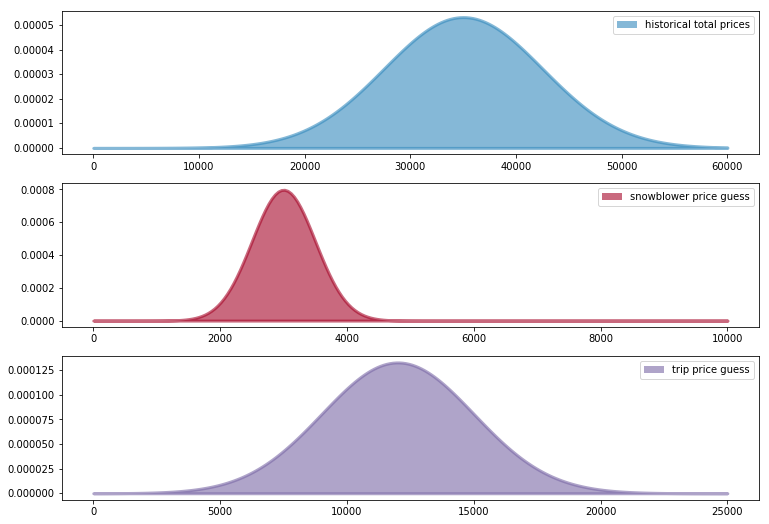

In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt

figsize(12.5, 9)

norm_pdf = stats.norm.pdf

plt.subplot(311)
x = np.linspace(0, 60000, 200)
sp1 = plt.fill_between(x, 0, norm_pdf(x, 35000, 7500),
                       color='#348ABD', lw=3, alpha=0.6,
                       label='historical total prices')
p1 = plt.Rectangle((0, 0), 1, 1, fc=sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])

plt.subplot(312)
x = np.linspace(0, 10000, 200)
sp2 = plt.fill_between(x, 0, norm_pdf(x, 3000, 500),
                       color='#A60628', lw=3, alpha=0.6,
                       label='snowblower price guess')
p2 = plt.Rectangle((0, 0), 1, 1, fc=sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])

plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x, 0, norm_pdf(x, 12000, 3000),
                       color='#7A68A6', lw=3, alpha=0.6,
                       label='trip price guess')
p3 = plt.Rectangle((0, 0), 1, 1, fc=sp3.get_facecolor()[0])
plt.legend([p3], [sp3.get_label()])

In [4]:
import pymc3 as pm

data_mu = [3e3, 12e3]
data_std = [5e2, 3e3]
mu_prior = 35e3
std_prior = 75e2

with pm.Model() as model:
    true_price = pm.Normal('true_price', mu=mu_prior, sd=std_prior)
    
    prize_1 = pm.Normal('first_prize', mu=data_mu[0], sd=data_std[0])
    prize_2 = pm.Normal('second_prize', mu=data_mu[1], sd=data_std[1])
    price_estimate = prize_1 + prize_2
    
    logp = pm.Normal.dist(mu=price_estimate, sd=(3e3)).logp(true_price)
    error = pm.Potential('error', logp)
    
    trace = pm.sample(50000, step=pm.Metropolis())
    burned_trace = trace[10000:]

price_trace = burned_trace['true_price']

c:\users\owner\anaconda3\envs\py3\lib\site-packages\pymc3\sampling.py:231: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically '
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:14<00:00, 3410.45it/s]


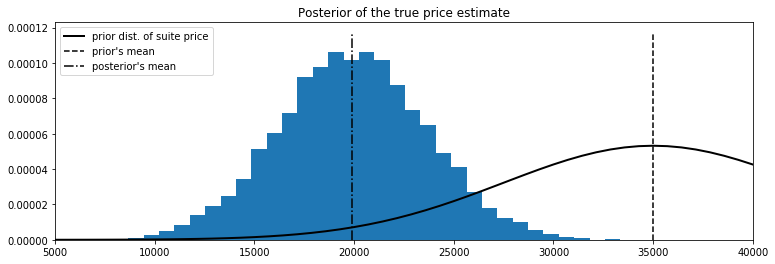

In [8]:
figsize(12.5, 4)
import scipy.stats as stats

x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c='k', lw=2,
         label='prior dist. of suite price')

_hist = plt.hist(price_trace, bins=35, normed=True, histtype='stepfilled')
plt.title('Posterior of the true price estimate')
plt.vlines(mu_prior, 0, 1.1*np.max(_hist[0]), label="prior's mean",
           linestyle='--')
plt.vlines(price_trace.mean(), 0, 1.1*np.max(_hist[0]), label="posterior's mean",
           linestyle='-.')
plt.xlim([5000, 40000])
plt.legend(loc='upper left')

In [10]:
def showdown_loss(guess, true_price, risk = 80000):
        loss = np.zeros_like(true_price)
        ix = true_price < guess
        loss[~ix] = np.abs(guess - true_price[~ix])
        close_mask = [abs(true_price - guess) <= 250]
        loss[close_mask] = -2*true_price[close_mask]
        loss[ix] = risk
        return loss

(5000, 30000)

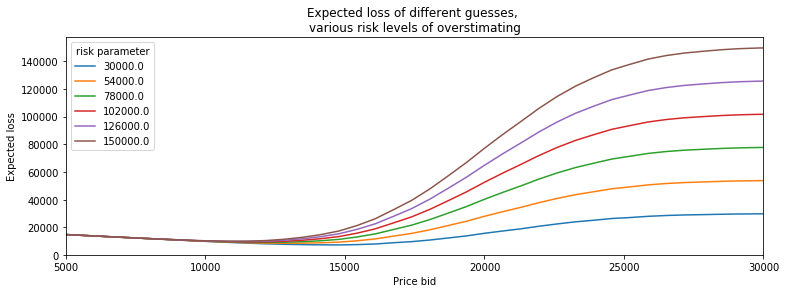

In [14]:
expected_loss = lambda guess, risk: showdown_loss(guess, price_trace, risk).mean()
guesses = np.linspace(5000, 50000, 70)
risks = np.linspace(30000, 150000, 6)

for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label='{}'.format(_p))

plt.title('Expected loss of different guesses, \n'
          'various risk levels of overstimating')
plt.legend(loc='upper left', title='risk parameter')
plt.xlabel('Price bid')
plt.ylabel('Expected loss')
plt.xlim(5000, 30000)